# Comparison of Methods: 'snaptogrid' vs. 'topology'

The data were obtained by geocoding with Lets-Plot.

The dataset **demo_geoms.geojson** contains geometries of some countries and states.

The dataset **geocoding.csv** contains the aggregated information about geometries from **demo_geoms.geojson**.

In [1]:
import pandas as pd
import geopandas as gpd

from lets_plot import *
from lets_plot.mapping import as_discrete


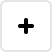
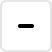
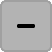
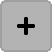
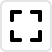
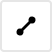
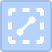
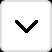
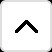
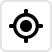

In [2]:
LetsPlot.setup_html()

In [3]:
CSV_INPUT = "data/geocoding.csv"
GEOJSON_INPUT = "data/demo_geoms.geojson"
COUNTRY_RESOLUTION_RANGE = list(range(1, 7))
STATE_RESOLUTION_RANGE = list(range(4, 10))
EXCLUDED_COUNTRIES = ["Italy", "Montenegro", "Poland"]
EXCLUDED_STATES = ["Alaska", "Hawaii"] + \
                  ["American Samoa", "Guam", "Northern Mariana Islands", "Puerto Rico", "United States Virgin Islands"]

In [4]:
df = pd.read_csv(CSV_INPUT)
df = df[~df["name"].isin(EXCLUDED_COUNTRIES)].reset_index(drop=True)
print(df.shape)
df.head()

(1830, 10)


version     kind    name  resolution  exterior_points_count  \
0  snaptogrid  country      US           1                    802   
1  snaptogrid  country  Canada           1                   2570   
2  snaptogrid  country   China           1                    432   
3  snaptogrid  country  Greece           1                     67   
4  snaptogrid  country      US           2                   1879   

   interior_points_count  points_count  points_ratio   diff_area  \
0                     69           871      0.004227   61.304494   
1                    670          3240      0.007282  135.639701   
2                      4           436      0.003025   34.835738   
3                     10            77      0.002458    7.397034   
4                    140          2019      0.009798   36.385796   

   rel_diff_area  
0       0.053319  
1       0.076367  
2       0.035971  
3       0.411959  
4       0.031986

In [5]:
countries_df = df[(df["kind"] == "country")&(df["resolution"].isin(COUNTRY_RESOLUTION_RANGE))].reset_index(drop=True)
print(countries_df.shape)

(48, 10)


In [6]:
states_df = df[(df["kind"] == "state")&(df["resolution"].isin(STATE_RESOLUTION_RANGE))].reset_index(drop=True)
print(states_df.shape)

(684, 10)


In [7]:
gdf = gpd.read_file(GEOJSON_INPUT)
print(gdf.shape)
gdf.head()

(712, 5)


name  resolution     version     kind  \
0      US           1  snaptogrid  country   
1  Canada           1  snaptogrid  country   
2   China           1  snaptogrid  country   
3  Greece           1  snaptogrid  country   
4   Italy           1  snaptogrid  country   

                                            geometry  
0  MULTIPOLYGON (((-95.62500 28.92163, -95.62500 ...  
1  MULTIPOLYGON (((-54.14062 47.51720, -54.84375 ...  
2  MULTIPOLYGON (((110.39062 19.97335, 111.09375 ...  
3  MULTIPOLYGON (((22.50000 36.59789, 22.50000 37...  
4  MULTIPOLYGON (((16.87500 39.90974, 16.87500 39...

In [8]:
states_gdf = gdf[(gdf["kind"] == "state")&(~gdf["name"].isin(EXCLUDED_STATES))]
print(states_gdf.shape)
states_gdf.head()

(600, 5)


name  resolution     version   kind  \
14        Vermont           1  snaptogrid  state   
15  Massachusetts           1  snaptogrid  state   
16       New York           1  snaptogrid  state   
17          Maine           1  snaptogrid  state   
18  New Hampshire           1  snaptogrid  state   

                                             geometry  
14  MULTIPOLYGON (((-71.71875 44.08759, -72.42188 ...  
15  MULTIPOLYGON (((-71.01562 42.03297, -71.71875 ...  
16  MULTIPOLYGON (((-73.12500 40.97990, -73.12500 ...  
17  MULTIPOLYGON (((-68.20312 44.59047, -68.20312 ...  
18  POLYGON ((-71.01562 43.06889, -71.01562 42.553...

## 1. Visual Comparison of Geometries Quality

In [9]:
def plot_states_comparison(gdf, *, resolutions=[], xlim=None, ylim=None):
    return ggplot() + \
        geom_map(aes(fill="name"), data=gdf[gdf["resolution"].isin(resolutions)], show_legend=False) + \
        facet_grid(x="version", y="resolution") + \
        coord_map(xlim=xlim, ylim=ylim) + \
        theme_bw() + theme(panel_grid='blank') + flavor_solarized_light() + \
        ggtitle("Compare States for Resolutions {0}".format(", ".join([str(i) for i in resolutions])))

In [10]:
plot_states_comparison(states_gdf, resolutions=[1, 2])

In [11]:
plot_states_comparison(states_gdf, resolutions=[5, 6], xlim=[-75, -70], ylim=[40, 42])

The 'topology' method seems to show better quality of geometries.

Since it is difficult to compare all geometries by eye, we will consider an additional metric.
The value of `rel_diff_area` is equal to the normalized symmetric difference between the versions of a geometry for resolutions 1 and 15.

## 2. Comparison of Errors

In [12]:
ggplot(countries_df, aes("resolution", "rel_diff_area", color="version")) + \
    geom_line(size=1, tooltips=layer_tooltips().format("@rel_diff_area", ".4f").line("@rel_diff_area")) + \
    facet_wrap(facets="name", scales='free_y', ncol=2) + \
    scale_color_brewer(type="qual", palette="Set1") + \
    theme_bw() + flavor_solarized_light() + \
    ggtitle("Reducing of the Error Size (rel_diff_area)")

In [13]:
ggplot(countries_df, aes("resolution", "rel_diff_area", color="version")) + \
    stat_summary(geom="line", size=1) + \
    scale_color_brewer(type="qual", palette="Set1") + \
    theme_bw() + flavor_solarized_light() + \
    ggtitle("Reducing of the Mean Error Size (by States)")

According to `rel_diff_area` values, the 'topology' method always gives the best quality.

## 3. Comparison of Points Count

In [14]:
ggplot(countries_df, aes("resolution", "points_count", fill="version")) + \
    geom_bar(stat='identity', position='dodge', width=.75, color="black") + \
    facet_wrap(facets="name", scales='free_y', ncol=2) + \
    scale_fill_brewer(type="qual", palette="Set1") + \
    theme_bw() + flavor_solarized_light() + \
    ggtitle("Geometry Points Count vs. Resolution")

In [15]:
ggplot(states_df, aes("resolution", "points_count", fill="version")) + \
    stat_summary(geom='bar', position='dodge', fun='mean', width=.75, color="black") + \
    scale_fill_brewer(type="qual", palette="Set1") + \
    theme_bw() + flavor_solarized_light() + \
    ggtitle("Mean Geometry Points Count (by States) vs. Resolution")

Also, with better quality, the 'topology' method requires fewer points per geometry.